<a href="https://colab.research.google.com/github/giedriusblazys/SDA_DS_class/blob/main/traditional_ml_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastai
!pip install eli5

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import time
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
pd.options.display.float_format = "{:,.2f}".format

In [ ]:
from fastcore.all import *
from fastai.vision.all import *

In [ ]:
from google.colab.patches import cv2_imshow # cv2_imshow performs convertion BGR2RGB itself

In [ ]:
def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

def plot_classification(y_true, y_pred):
    target_names = searches
    labels_names = [0, 1] 
    print(classification_report(y_true, y_pred,labels=labels_names, target_names=target_names))    
    cm = confusion_matrix(y_true, y_pred,labels=labels_names)  #, normalize='true'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()

In [ ]:
urls = search_images('bird photos', max_images=1)
urls[0]

'http://2.bp.blogspot.com/_LDF9z4ZzZHo/TQZJGDvUEcI/AAAAAAAAAfk/3CUiiHN4w34/s1600/bird_1010.jpg'

In [ ]:
# searches = 'red tomato', 'green tomato'
# path = Path('/content/gdrive/My Drive/data/ripe_or_not')

searches = 'happy person', 'sad person'
path = Path('/content/gdrive/My Drive/data/mood')

# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f'{o} photo'))
#     resize_images(path/o, max_size=400, dest=path/o)

In [ ]:
failed = verify_images(get_image_files(path)) # Select files, which are not images
failed.map(Path.unlink) # Path.unlink deletes files
len(failed)

0

In [ ]:
failed

(#0) []

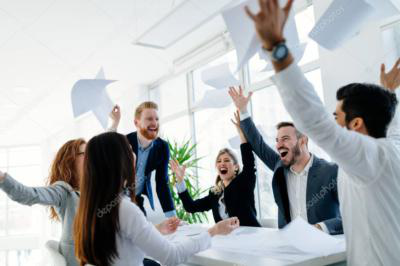

In [ ]:
img_paths = get_image_files(path)
selected_path = str(img_paths[0])
im = Image.open(selected_path)
im

In [ ]:
def get_contour(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,thresh1 = cv2.threshold(image,50,255,cv2.THRESH_BINARY)

    contours, hierarchy	=	cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = []
    childs_list = []
    for contour, h in zip(contours, hierarchy[0]):
        if h[3] == -1:
            return contour, len(contours)-1

In [ ]:
def get_features(cnt, childs):
    moments = cv2.moments(cnt)
    hu_moments = cv2.HuMoments(moments)
    features = {f'hu_{x}': hu[0] for x, hu in enumerate(hu_moments)}
    contour_area = cv2.contourArea(cnt)
    arc_length = cv2.arcLength(cnt, True)
    try:
        features['circularity'] = 4 * 3.14 * contour_area / arc_length**2
    except ZeroDivisionError:
        features['circularity'] = 0
    features['childs'] = childs
    
    return features


def lab_color_moments(img):
    # Convert BGR to LAB colorspace
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # Split the channels
    l, a, b = cv2.split(img_lab)
    # Initialize the color feature
    color_feature = {}
    color_feature['l_mean'] = np.mean(l)  
    color_feature['a_mean'] = np.mean(a) 
    color_feature['b_mean'] = np.mean(b)  
    return color_feature


def hsv_color_moments(img):
    # Convert BGR to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Split the channels - h,s,v
    h, s, v = cv2.split(hsv)
    # Initialize the color feature
    color_feature = {}
    # N = h.shape[0] * h.shape[1]
    # The first central moment - average
    color_feature['h_mean'] = np.mean(h)  # np.sum(h)/float(N)
    color_feature['s_mean'] = np.mean(s)  # np.sum(s)/float(N)
    color_feature['v_mean'] = np.mean(v)  # np.sum(v)/float(N)
    # The second central moment - standard deviation
    color_feature['h_std'] = np.std(h)  # np.sqrt(np.mean(abs(h - h.mean())**2))
    color_feature['s_std'] = np.std(s)  # np.sqrt(np.mean(abs(s - s.mean())**2))
    color_feature['v_std'] = np.std(v)  # np.sqrt(np.mean(abs(v - v.mean())**2))
    # The third central moment - the third root of the skewness
    h_skewness = np.mean(abs(h - h.mean())**3)
    s_skewness = np.mean(abs(s - s.mean())**3)
    v_skewness = np.mean(abs(v - v.mean())**3)
    color_feature['h_thirdMoment'] = h_skewness**(1./3)
    color_feature['s_thirdMoment'] = s_skewness**(1./3)
    color_feature['v_thirdMoment'] = v_skewness**(1./3)
    return color_feature

## Let's build a dataset with image features

In [ ]:
searches

('happy person', 'sad person')

In [ ]:
features_list = []
for i, o_path in enumerate(img_paths):
    img = cv2.imread(str(o_path), 1)
    contour, childs = get_contour(img)
    img_features = get_features(contour, childs)
    img_features.update(hsv_color_moments(img))
    img_features.update(lab_color_moments(img))
    img_features['class'] = (o_path.parent.name == searches[1])
    features_list.append(img_features)

In [ ]:
target = 'class'
df = pd.DataFrame(features_list, index=img_paths)
y = df.pop(target)
x = df.copy()

X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.8, random_state=42)
print(f'Train set rows: {len(X_train)}')
print(f'Test set rows: {len(X_test)}')

Train set rows: 448
Test set rows: 112


In [ ]:
rf_model = RandomForestClassifier(random_state=0, n_estimators=20, max_depth=12, min_samples_split=5).fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print()
print('******* Random Forest *******')
print()
print(f'Validation Accuracy: {accuracy_score(y_test, y_pred)}')



******* Random Forest *******

Validation Accuracy: 0.8482142857142857


In [ ]:
perm = PermutationImportance(rf_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0589 ± 0.0242,l_mean
0.0482 ± 0.0143,s_mean
0.0411 ± 0.0385,h_std
0.0339 ± 0.0286,v_mean
0.0214 ± 0.0401,s_std
0.0214 ± 0.0214,h_mean
0.0179 ± 0.0553,s_thirdMoment
0.0179 ± 0.0196,v_std
0.0161 ± 0.0134,hu_0
0.0143 ± 0.0143,v_thirdMoment


              precision    recall  f1-score   support

happy person       0.84      0.92      0.88        66
  sad person       0.87      0.74      0.80        46

    accuracy                           0.85       112
   macro avg       0.85      0.83      0.84       112
weighted avg       0.85      0.85      0.85       112



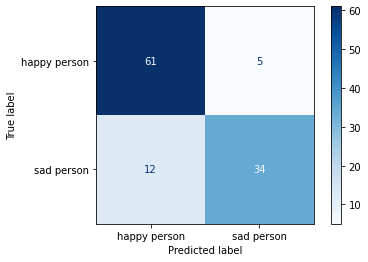

In [ ]:
plot_classification(y_test, y_pred)

### Misclassified examples

True: sad person, Predicted: happy person


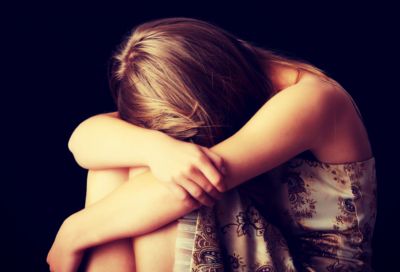

In [ ]:
print(f'True: {searches[1]}, Predicted: {searches[0]}')
idx = (y_test==1) & (y_pred==0)
selected_path = str(X_test[idx].index[2])
img = cv2.imread(selected_path, 1)
# img = cv2.cvtColor(brg_img, cv2.COLOR_BGR2RGB)
cv2_imshow(img)

True: happy person, Predicted: sad person


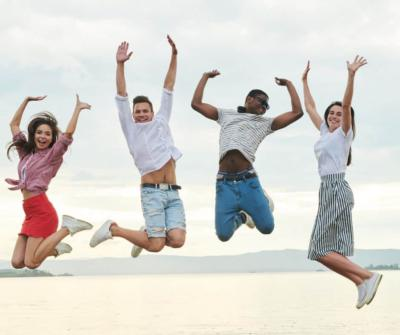

In [ ]:
print(f'True: {searches[0]}, Predicted: {searches[1]}')
idx = (y_test==0) & (y_pred==1)
selected_path = str(X_test[idx].index[2])
img = cv2.imread(selected_path, 1)
# img = cv2.cvtColor(brg_img, cv2.COLOR_BGR2RGB)
cv2_imshow(img)

### Deep learning approach

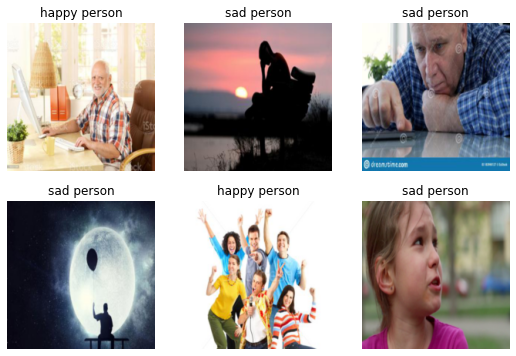

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.085170,0.304330,0.857143,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.330548,0.312257,0.875000,00:05
1,0.219498,0.209580,0.919643,00:05
2,0.148088,0.188800,0.928571,00:05


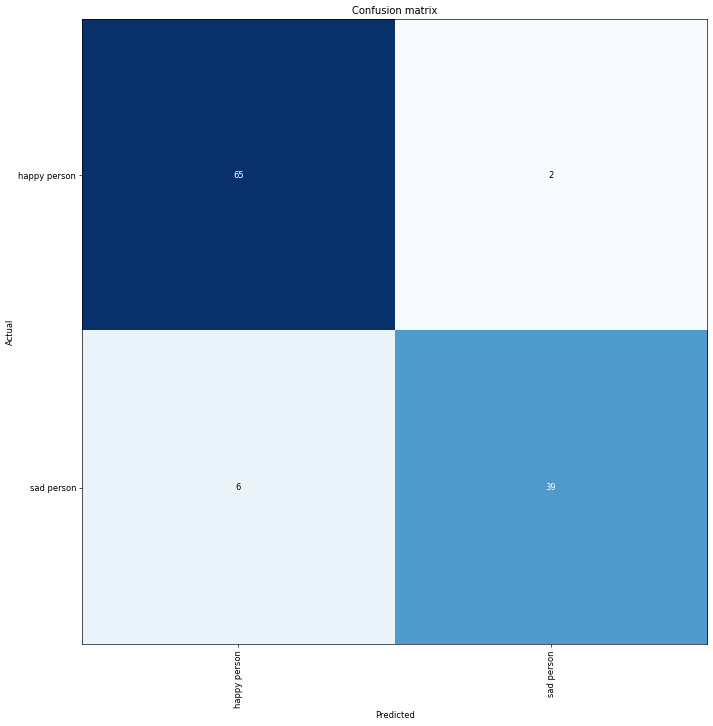

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

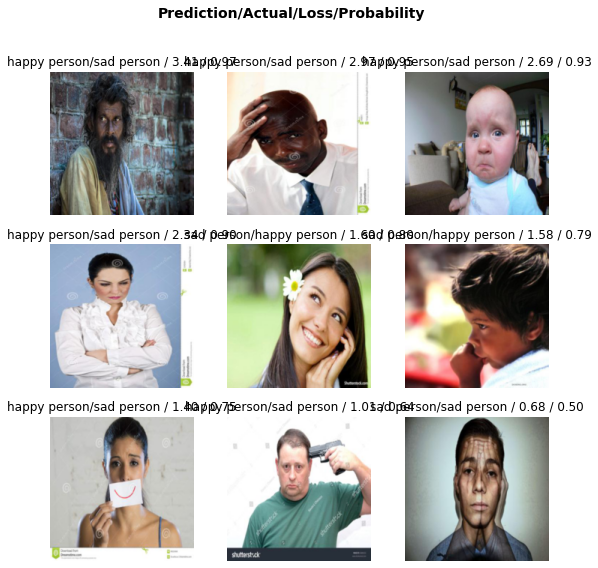

In [ ]:
interp.plot_top_losses(9, nrows=3)